# Gaussian Process Regression with Automatic Relevance Determination (ARD)

In [1]:
import matplotlib as mpl; mpl.use('pgf')

In [2]:
%matplotlib inline

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os

from pathlib import Path

In [4]:
golden_ratio = 0.5 * (1 + np.sqrt(5))
golden_size = lambda width: (width, width / golden_ratio)

In [5]:
width = 10

rc = {
    "figure.figsize": golden_size(width),
    "text.usetex": False,
}

sns.set(context="notebook", style="ticks", palette="colorblind", font="serif", rc=rc)

In [6]:
def preprocess(df):

    new_df = df.assign(timestamp=pd.to_datetime(df.timestamp, unit='s'))
    elapsed_delta = new_df.timestamp - new_df.timestamp.min()

    return new_df.assign(elapsed=elapsed_delta.dt.total_seconds())

In [7]:
def extract_series(df, index="elapsed", column="nelbo"):

    new_df = df.set_index(index)
    series = new_df[column]

    # (0) save last timestamp and value
#     series_final = series.tail(n=1)

    # (1) de-duplicate the values (significantly speed-up
    # subsequent processing)
    # (2) de-duplicate the indices (it is entirely possible
    # for some epoch of two different tasks to complete
    # at the *exact* same time; we take the one with the
    # smaller value)
    # (3) add back last timestamp and value which can get
    # lost in step (1)
    new_series = series.drop_duplicates(keep="first") \
                       .groupby(level=index).min()
#                        .append(series_final)

    return new_series

In [8]:
def merge_stack_runs(series_dict, seed_key="seed", y_key="nelbo",
                     drop_until_all_start=False):

    merged_df = pd.DataFrame(series_dict)

    # fill missing values by propagating previous observation
    merged_df.ffill(axis="index", inplace=True)

    # NaNs can only remain if there are no previous observations
    # i.e. these occur at the beginning rows.
    # drop rows until all runs have recorded observations.
    if drop_until_all_start:
        merged_df.dropna(how="any", axis="index", inplace=True)

    # TODO: Add option to impute with row-wise mean, which looks something like:
    #    (values in Pandas can only be filled column-by-column, so need to
    #     transpose, fillna and transpose back)
    # merged_df = merged_df.T.fillna(merged_df.mean(axis="columns")).T

    merged_df.columns.name = seed_key
    stacked_df = merged_df.stack(level=seed_key)

    stacked_df.name = y_key
    data = stacked_df.reset_index()

    return data

In [9]:
def make_plot_data(names, seeds, summary_dir,
                   process_run_fn=None,
                   extract_series_fn=None,
                   seed_key="seed",
                   y_key="nelbo"):

    base_path = Path(summary_dir)

    if process_run_fn is None:

        def process_run_fn(run_df):
            return run_df

    df_list = []

    for name in names:

        path = base_path.joinpath(name)
        seed_dfs = dict()

        for seed in seeds:

            csv_path = path.joinpath(f"scalars.{seed:03d}.csv")
            seed_df = pd.read_csv(csv_path)

            seed_dfs[seed] = process_run_fn(seed_df)

        if extract_series_fn is not None:

            series_dict = {seed: extract_series_fn(seed_df)
                           for seed, seed_df in seed_dfs.items()}

            name_df = merge_stack_runs(series_dict, seed_key=seed_key, y_key=y_key).assign(name=name)

        else:

            name_df = pd.concat(seed_dfs.values(), axis="index", sort=True)

        df_list.append(name_df)

    data = pd.concat(df_list, axis="index", sort=True)

    return data

In [10]:
names = ["optimal", "optimal_random_init", "optimal_random_init_cumsum"]
seeds = range(3)
summary_dir = "../../logs"

In [11]:
data = make_plot_data(names, seeds, summary_dir=summary_dir)
data

,amplitude,beta1,beta2,epoch,learning_rate,length_scale,name,nelbo,observation_noise_variance,seed,timestamp
0,1.006506,0.9,0.99,0,0.001,0.365473,optimal,1117.510202,0.006785,0,1.582762e+09
1,1.013960,0.9,0.99,1,0.001,0.362741,optimal,1093.650125,0.006840,0,1.582762e+09
2,1.021540,0.9,0.99,2,0.001,0.360009,optimal,1072.029277,0.006894,0,1.582762e+09
3,1.029125,0.9,0.99,3,0.001,0.357327,optimal,1052.153441,0.006949,0,1.582762e+09
4,1.036685,0.9,0.99,4,0.001,0.354703,optimal,1033.977712,0.007004,0,1.582762e+09
...,...,...,...,...,...,...,...,...,...,...,...
595,0.777385,0.9,0.99,595,0.001,2.487967,optimal_random_init_cumsum,117.663659,0.422302,2,1.582762e+09
596,0.779921,0.9,0.99,596,0.001,2.491256,optimal_random_init_cumsum,117.626169,0.424746,2,1.582762e+09
597,0.782454,0.9,0.99,597,0.001,2.494537,optimal_random_init_cumsum,117.590871,0.427193,2,1.582762e+09
598,0.784984,0.9,0.99,598,0.001,2.497800,optimal_random_init_cumsum,117.555706,0.429643,2,1.582762e+09


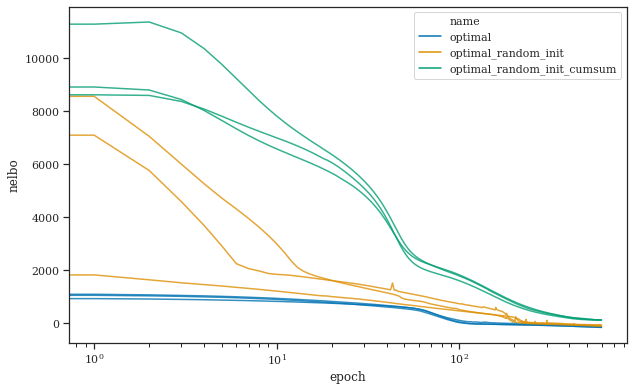

In [12]:
fig, ax = plt.subplots()

sns.lineplot(x='epoch', y='nelbo', hue="name", 
             units="seed", estimator=None, 
#              ci="sd", 
             data=data, alpha=0.8, ax=ax)

ax.set_xscale("log")
# ax.set_yscale("log")

plt.show()

In [13]:
data = make_plot_data(names, seeds, summary_dir,
                      process_run_fn=preprocess,
                      extract_series_fn=extract_series)
data

,elapsed,name,nelbo,seed
0,0.000000,optimal,1117.510202,0
1,0.000000,optimal,946.381757,1
2,0.000000,optimal,1075.766094,2
3,0.034032,optimal,1093.650125,0
4,0.034032,optimal,946.381757,1
...,...,...,...,...
5389,18.965976,optimal_random_init_cumsum,125.215073,1
5390,18.965976,optimal_random_init_cumsum,117.520633,2
5391,18.977120,optimal_random_init_cumsum,126.739482,0
5392,18.977120,optimal_random_init_cumsum,125.139793,1


In [14]:
?np.zeros

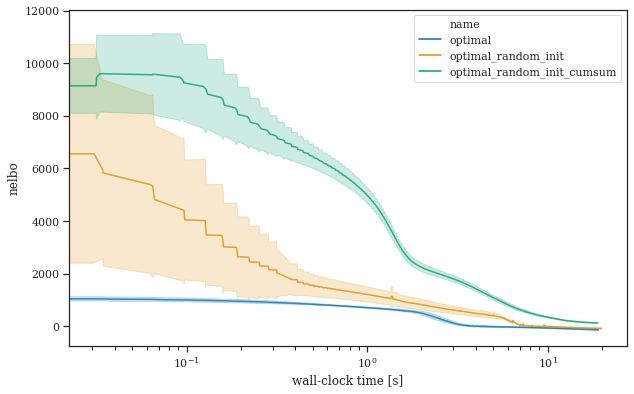

In [16]:
fig, ax = plt.subplots()

sns.lineplot(x='elapsed', y='nelbo', hue="name", 
#              units="seed", estimator=None, 
             ci="sd", 
             data=data, alpha=0.8, ax=ax)

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("wall-clock time [s]")

plt.show()